# Setup


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

DATA_DIR = Path.cwd().parent / "data"

DATA_DIR

PosixPath('/workspaces/isic/data')

In [3]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

device(type='cuda')

In [4]:
import torch

generator = torch.Generator().manual_seed(42)

In [5]:
import torch

torch.set_float32_matmul_precision("high")

# Dataset


In [6]:
TRAIN_IMAGES_FILE = DATA_DIR / "train-image.hdf5"
TRAIN_METADATA_FILE = DATA_DIR / "train-metadata.csv"

TRAIN_IMAGES_FILE, TRAIN_METADATA_FILE

(PosixPath('/workspaces/isic/data/train-image.hdf5'),
 PosixPath('/workspaces/isic/data/train-metadata.csv'))

In [7]:
from isic.dataset import ISICDataset

ds = ISICDataset(TRAIN_IMAGES_FILE, TRAIN_METADATA_FILE)

len(ds)

401059

ISIC_0015670 0


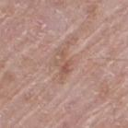

ISIC_0015845 0


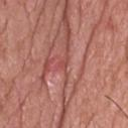

ISIC_0015864 0


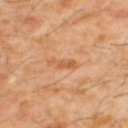

ISIC_0015902 0


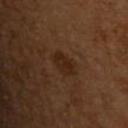

ISIC_0024200 0


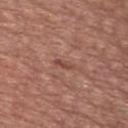

In [8]:
for i in range(5):
    metadata, image, target = ds[i]
    print(metadata["isic_id"], target)
    image.resize((128, 128)).show()

# Metadata Preprocessing


In [9]:
from sklearn.preprocessing import OneHotEncoder

sex_enc = OneHotEncoder(categories=[["male", "female"]], handle_unknown="ignore")
anatom_site_general_enc = OneHotEncoder(
    categories=[
        [
            "head/neck",
            "upper extremity",
            "lower extremity",
            "posterior torso",
            "anterior torso",
        ]
    ],
    handle_unknown="ignore",
)

sex_enc = sex_enc.fit(ds.metadata[["sex"]])
anatom_site_general_enc = anatom_site_general_enc.fit(
    ds.metadata[["anatom_site_general"]]
)

In [10]:
import torch
import pandas as pd
from sklearn.preprocessing import minmax_scale


def to_tensor(series: pd.Series) -> torch.Tensor:
    # Convert series to single-row DataFrame for consistent operations
    df = series.loc[["age_approx", "sex", "anatom_site_general"]].to_frame().T

    # Handle age_approx: convert to numeric first, then fillna, then normalize
    df.loc[:, "age_approx"] = pd.to_numeric(df["age_approx"], errors="coerce").fillna(0)
    df.loc[:, "age_approx"] = minmax_scale(df.loc[:, "age_approx"])

    # One-hot encode sex
    one_hot_sex = sex_enc.transform(df[["sex"]]).toarray()
    for i, category in enumerate(sex_enc.categories_[0]):
        df[f"is_{category}"] = one_hot_sex[:, i]
    df = df.drop(columns=["sex"])

    # One-hot encode anatomical site
    one_hot_anatom_site_general = anatom_site_general_enc.transform(
        df[["anatom_site_general"]]
    ).toarray()
    for i, category in enumerate(anatom_site_general_enc.categories_[0]):
        df[f"anatom_site_general_is_{category}"] = one_hot_anatom_site_general[:, i]
    df = df.drop(columns=["anatom_site_general"])

    # Ensure all columns are numeric before tensor conversion
    df = df.astype(float)
    return torch.tensor(df.iloc[0].values, dtype=torch.float32)

# Experiment Setup


In [11]:
params = {"epochs": 3, "batch_size": 128, "learning_rate": 0.001, "image_size": 128}

epochs = params["epochs"]
batch_size = params["batch_size"]
lr = params["learning_rate"]
img_size = params["image_size"], params["image_size"]

In [12]:
import mlflow

mlflow.set_tracking_uri("http://localhost:5000")
mlflow.set_experiment("mlp")

mlflow.log_params(params)

mlflow.pytorch.autolog()

2025/08/11 14:49:22 INFO mlflow.tracking.fluent: Experiment with name 'mlp' does not exist. Creating a new experiment.
2025/08/11 14:49:22 WARNING mlflow.utils.autologging_utils: MLflow pytorch autologging is known to be compatible with 2.1.0 <= torch <= 2.7.1, but the installed version is 2.7.1+cu126. If you encounter errors during autologging, try upgrading / downgrading torch to a compatible version, or try upgrading MLflow.


# Model Definition


In [13]:
from isic.models import MLP

model = MLP(img_size).to(device)

model

MLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (image_stack): Sequential(
    (0): Linear(in_features=49152, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): ReLU()
  )
  (metadata_stack): Sequential(
    (0): Linear(in_features=8, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=32, bias=True)
    (3): ReLU()
  )
  (output_stack): Sequential(
    (0): Linear(in_features=64, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=1, bias=True)
  )
)

In [14]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

total_params

6303793

# Training


In [15]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

print(f"Model device: {next(model.parameters()).device}")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")
print(
    f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}"
)

Model device: cuda:0
Total parameters: 6,303,793
Trainable parameters: 6,303,793


Calculate class weights based on inverse frequency  
With ~1019:1 ratio, we need to heavily weight the minority class


In [16]:
class_counts = [400666, 393]  # [benign, malignant] from EDA
total_samples = sum(class_counts)
class_weights = [total_samples / (2.0 * count) for count in class_counts]

print("Class Distribution:")
print(f"Benign: {class_counts[0]:,} samples")
print(f"Malignant: {class_counts[1]:,} samples")
print(f"Imbalance ratio: {class_counts[0] / class_counts[1]:.1f}:1")

print("\nCalculated class weights:")
print(f"Benign weight: {class_weights[0]:.4f}")
print(f"Malignant weight: {class_weights[1]:.4f}")
print(f"Weight ratio: {class_weights[1] / class_weights[0]:.1f}:1 (malignant:benign)")

Class Distribution:
Benign: 400,666 samples
Malignant: 393 samples
Imbalance ratio: 1019.5:1

Calculated class weights:
Benign weight: 0.5005
Malignant weight: 510.2532
Weight ratio: 1019.5:1 (malignant:benign)


Use weighted BCE loss to handle class imbalance


In [17]:
import torch.nn as nn

pos_weight = torch.tensor([class_weights[1] / class_weights[0]], device=device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
print(f"Loss function: BCEWithLogitsLoss with pos_weight={pos_weight.item():.1f}")

Loss function: BCEWithLogitsLoss with pos_weight=1019.5


In [18]:
from torch.utils.data import DataLoader, random_split
from torchvision.transforms.functional import pil_to_tensor


def collate(batch):
    """Custom collate function for training data"""
    metadatas, images, targets = zip(*batch)

    # Process images: resize, convert to tensor, normalize
    x_imgs = torch.stack(
        [pil_to_tensor(img.resize(img_size)).float() / 255.0 for img in images]
    )

    # Process metadata: convert to tensors
    x_mds = torch.stack([to_tensor(md) for md in metadatas])

    # Targets
    targets = torch.tensor(targets, dtype=torch.float32)

    return x_imgs, x_mds, targets


train_size = int(0.8 * len(ds))
val_size = len(ds) - train_size
train_dataset, val_dataset = random_split(
    ds, [train_size, val_size], generator=generator
)

print("Dataset sizes:")
print(f"Total: {len(ds):,}")
print(f"Train: {len(train_dataset):,}")
print(f"Validation: {len(val_dataset):,}")

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate,
    generator=generator,
)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate,
    generator=generator,
)

print(f"Batches per epoch - Train: {len(train_loader)}, Val: {len(val_loader)}")

Dataset sizes:
Total: 401,059
Train: 320,847
Validation: 80,212
Batches per epoch - Train: 2507, Val: 627


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
from isic.training import train, validate

best_val_f1 = 0

for epoch in range(epochs):
    print(f"\nEpoch {epoch + 1}/{epochs}")
    print("-" * 40)

    # Train
    train_metrics = train(model, train_loader, criterion, optimizer, device)

    # Validate
    val_metrics, val_targets, val_predictions = validate(
        model, val_loader, criterion, device
    )

    print(f"\nEpoch {epoch + 1} Results:")
    print("🔸 TRAINING:")
    print(
        f"   Loss: {train_metrics['loss']:.4f} | Accuracy: {train_metrics['accuracy']:.4f}"
    )
    print(
        f"   Precision: {train_metrics['precision']:.4f} | Recall: {train_metrics['recall']:.4f}"
    )
    print(
        f"   F1-Score: {train_metrics['f1']:.4f} | Specificity: {train_metrics['specificity']:.4f}"
    )

    print("🔸 VALIDATION:")
    print(
        f"   Loss: {val_metrics['loss']:.4f} | Accuracy: {val_metrics['accuracy']:.4f}"
    )
    print(
        f"   Precision: {val_metrics['precision']:.4f} | Recall: {val_metrics['recall']:.4f}"
    )
    print(
        f"   F1-Score: {val_metrics['f1']:.4f} | Specificity: {val_metrics['specificity']:.4f}"
    )
    print(f"   ROC-AUC: {val_metrics['roc_auc']:.4f}")

    # Track best model by F1-score
    if val_metrics["f1"] > best_val_f1:
        best_val_f1 = val_metrics["f1"]
        print(f"✅ New best F1-score: {best_val_f1:.4f}")

    # Medical interpretation
    if val_metrics["recall"] > 0:
        print("🏥 MEDICAL INTERPRETATION:")
        print(
            f"   Sensitivity (recall): {val_metrics['recall']:.1%} of malignant cases detected"
        )
        print(
            f"   Specificity: {val_metrics['specificity']:.1%} of benign cases correctly identified"
        )

print("\n🎯 Training Summary:")
print(f"Best validation F1-score: {best_val_f1:.4f}")

# final results
print("\n📊 Final Validation Results (Class-Weighted Model):")
cm = confusion_matrix(val_targets, val_predictions)
print("Confusion Matrix:")
print("                    Predicted")
print("                Benign  Malignant  Total")
print(f"Actual Benign     {cm[0, 0]:4d}      {cm[0, 1]:4d}   {cm[0, 0] + cm[0, 1]:4d}")
print(
    f"    Malignant     {cm[1, 0]:4d}      {cm[1, 1]:4d}     {cm[1, 0] + cm[1, 1]:3d}"
)

# Calculate key medical metrics
if cm[1, 0] + cm[1, 1] > 0:  # If there are malignant cases
    sensitivity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
    missed_malignant = cm[1, 0]
    detected_malignant = cm[1, 1]

    print("\n🏥 CRITICAL MEDICAL METRICS:")
    print(f"• Malignant cases in validation: {cm[1, 0] + cm[1, 1]}")
    print(f"• Malignant cases DETECTED: {detected_malignant}")
    print(f"• Malignant cases MISSED: {missed_malignant}")
    print(f"• Sensitivity (Detection Rate): {sensitivity:.1%}")

    if missed_malignant > 0:
        print(f"⚠️  WARNING: {missed_malignant} malignant cases would go undiagnosed!")

print("\nDetailed Classification Report:")
print(
    classification_report(
        val_targets, val_predictions, target_names=["Benign", "Malignant"], digits=4
    )
)


Epoch 1/3
----------------------------------------
Batch   0/2507: Loss: 0.7094 | Acc: 0.00%
Batch 100/2507: Loss: 0.4816 | Acc: 93.00%
Batch 200/2507: Loss: 0.4599 | Acc: 96.42%
Batch 300/2507: Loss: 6.7889 | Acc: 97.58%
